In [ ]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

In [1]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("ANTHROPIC_API_KEY")      # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("OPENAI_MODEL")           # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")
_set_if_undefined("ANTHROPIC_MODEL")        # Model name (e.g., "claude-3-7-sonnet-latest")

In [ ]:
# Multi-Agent Orchestration with LangGraph:
#- Supervisor agent coordinates between specialized workers.
#- Workers: weather reporting agent, dressing planner agent, image generator.
# ---- Imports ----
import os
from langchain_openai import ChatOpenAI
from typing import Annotated
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from openai import OpenAI
import base64

# ---- LLM Setup ----

# Load the default model from environment variables
default_model = os.environ["OPENAI_MODEL"]

# Initialize the LLM (Large Language Model) interface
llm = ChatOpenAI(model=default_model)

@tool
def gpt_image_1_tool(text: Annotated[str, "image description"]):
    """Tool to generate image for a given text."""
    
    client = OpenAI()
    default_model = os.environ["OPENAI_MODEL"]
    response = client.responses.create(
        model=default_model,
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": text}
                ],
            }
        ],
        tools=[{"type": "image_generation"}],
    )

    image_generation_calls = [
        output
        for output in response.output
        if output.type == "image_generation_call"
    ]

    image_data = [output.result for output in image_generation_calls]
    
    file_path = os.path.join(os.getcwd(), "image-1.png")  # This will save the image in the current working directory
    

    if image_data:
        image_base64 = image_data[0]
        with open(file_path, "wb") as f:
            f.write(base64.b64decode(image_base64))
    else:
        print(response.output.content)

    return file_path

# ---- Node Definitions ----

# Image generation Agent
image_generation_agent = create_react_agent(
    llm,
    tools=[gpt_image_1_tool],
    name="image_generation_agent",
    prompt=(
        "You are an image generator. Generate an image of a person dressed as suggusted in the given text. "
        "You may use tools."
    )
)

@tool
def weather_reporting_tool(city: Annotated[str, "name of the city"]):
    """Tool to fetch current weather data for a given city."""
    # (Simulated API call — replace with real API integration)
    json_data = {
        "weather": {
            "city": city,
            "main": "Rain",
            "description": "moderate rain",
            "temp": 284.2,
            "feels_like": 282.93,
            "temp_min": 283.06,
            "temp_max": 286.82,
            "pressure": 1021,
            "humidity": 60,
            "sea_level": 1021,
            "grnd_level": 910
        }
    }
    return json_data

# Weather Reporting Agent
weather_reporting_agent = create_react_agent(
    llm,
    tools=[weather_reporting_tool],
    name="weather_reporting_agent",
    prompt=(
        "You are a weather reporter. Report current weather for the provided city. "
        "You may use tools. Do not suggest what to wear."
    )
)

@tool
def uv_index_reporting_tool(city: Annotated[str, "name of the city"]):
    """Tool to return current UV index for a given city."""
    # (Simulated API call — replace with real API integration)
    json_data = {
        "uvindex": {
            "city": city,
            "value": "4", # 0-2 low: no protective measures necessary. 
                          # 3-5 moderate: protection necessary. 
                          # 6-7 high: protection necessary. 
                          # 8-10 very high: special protection necessary. 
                          # 11-12 extreme: special protection necessary.
        }
    }
    return json_data

# UV Index Agent
uv_index_reporting_agent = create_react_agent(
    llm,
    tools=[uv_index_reporting_tool],
    name="uv_index_reporting_agent",
    prompt=(
        "You are a UV Index reporter. Based on the provided UV Index value for the city, "
        "report the current guidance as follows: "
        "    0-2 (Low): No protective measures necessary. "
        "    3-5 (Moderate): Protection necessary. "
        "    During midday hours, seek shade, wear appropriate clothing, a hat, and sunglasses, and use sunscreen with sufficient SPF for uncovered skin. "
        "    6-7 (High): Protection necessary. "
        "    During midday hours, seek shade, wear appropriate clothing, a hat, and sunglasses, and use sunscreen with sufficient SPF for uncovered skin. "
        "    8-10 (Very High): Special protection necessary. "
        "    Avoid being outdoors at midday. If this isn’t possible, seek shade. Wear sunglasses, appropriate clothing, and a wide-brimmed hat. Apply sun cream with a high SPF. "
        "    11-12 (Extreme): Special protection necessary. Avoid being outdoors"
        "You may use tools."
    )
)

# Dressing Planner Agent
adults_dressing_planner_agent = create_react_agent(
    llm,
    tools=[],
    name="adults_dressing_planner_agent",
    prompt=(
        "You suggest dressing options for adults based on the current weather and UV index. "
        "Prioritize UV index, 'feels like' temperature and consider wind conditions."
    )
)

# Dressing Planner Agent
childrens_dressing_planner_agent = create_react_agent(
    llm,
    tools=[],
    name="childrens_dressing_planner_agent",
    prompt=(
        "You suggest dressing options for children based on the current weather and UV index. "
        "Prioritize UV index, 'feels like' temperature and consider wind conditions."
    )
)

# ---- Supervisor Setup ----

# System prompt guiding the supervisor's behavior
weather_system_prompt = (
    "# Role and Objective"
    "You are a Supervisor Agent tasked with managing a conversation between multiple specialized workers: "
    "`weather_reporting_agent`, and `uv_index_reporting_agent`."
    "Your goal is to find current weather, and UV index for a given city."
    "orchestrate worker actions to resolve the user's request efficiently."
    "# Instructions"
    " - Persist through multiple steps until the task is fully complete."
    " - Always select the next worker based on context."
    " - Think step-by-step before choosing a worker and after receiving results."
    "# Reasoning Steps"
    "1. Analyze current state."
    "2. Plan the next best action."
    "3. Reflect after worker output."
    "4. Repeat until completion."
    "# Tool/Worker Use"
    "- `weather_reporting_agent`: gather or analyze weather."
    "- `uv_index_reporting_agent`: gather or analyze UV index and provide guidance according to the UV index value"
)

# Create supervisors
weather_supervisor = create_supervisor(
    agents=[weather_reporting_agent, uv_index_reporting_agent],
    model=llm,
    prompt=(weather_system_prompt),
    supervisor_name="weather_supervisor"
)

weather_team = weather_supervisor.compile(name="weather_team")

# System prompt guiding the supervisor's behavior
dressing_system_prompt = (
    "# Role and Objective"
    "You are a Supervisor Agent tasked with managing a conversation between multiple specialized workers: "
    "`adults_dressing_planner_agent`, `childrens_dressing_planner_agent`, and `image_generation_agent`."
    "Your goal is to suggest dressing options based on the weather, UV index and persons age and"
    "generate a photo-realistic picture of a person dressed according to the suggestion."
    "orchestrate worker actions to resolve the user's request efficiently."
    "# Instructions"
    " - Persist through multiple steps until the task is fully complete."
    " - Always select the next worker based on context."
    " - Think step-by-step before choosing a worker and after receiving results."
    "# Reasoning Steps"
    "1. Analyze current state."
    "2. Plan the next best action."
    "3. Reflect after worker output."
    "4. Repeat until completion."
    "# Tool/Worker Use"
    "- `adults_dressing_planner_agent`: suggest clothing for adults based on the weather and UV index"
    "- `childrens_dressing_planner_agent`: suggest clothing for children based on the weather and UV index"
    "- `image_generation_agent`: generates image of a person wearing given dressing suggestion."
)

# Create supervisor
dressing_supervisor = create_supervisor(
    agents=[adults_dressing_planner_agent, childrens_dressing_planner_agent, image_generation_agent],
    model=llm,
    prompt=(dressing_system_prompt),
    supervisor_name="dressing_supervisor"
)

dressing_team = dressing_supervisor.compile(name="dressing_team")


In [13]:
# Create supervisor workflow
# uv index agent, weather reporting agent, childrens vs adults dressing planner
top_level_supervisor = create_supervisor(
    agents=[weather_team, dressing_team],
    model=llm,
    prompt=(
        "You are a team supervisor managing a team of weather and a dressing experts. "
        "Your task is to provide dressing suggestions based on the user query. "
        "User input will include city name and their age and based on that information do the following: "
        "- Use appropriate agents and teams to find current weather and UV index for the given city, "
        "- based on the result and users age suggest appropriate clothing options "
        "- and Use image generation agent in dressing team to generate a picture of a person wearing suggested clothing. "
        "- Do not use example images from the internet. "
        "Here is the user input: "
    ),
    supervisor_name="top_level_supervisor"
)

# Compile and run
hierarchy = top_level_supervisor.compile()



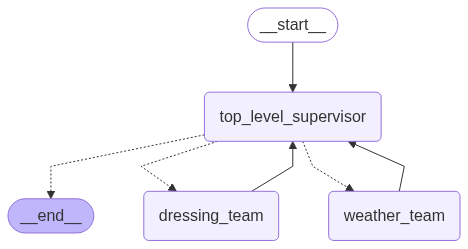

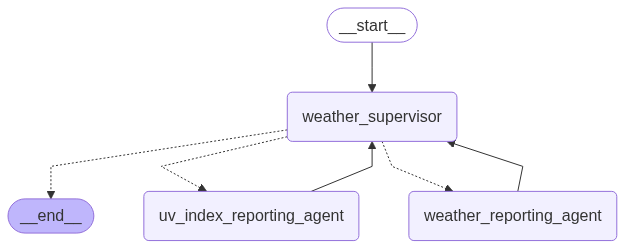

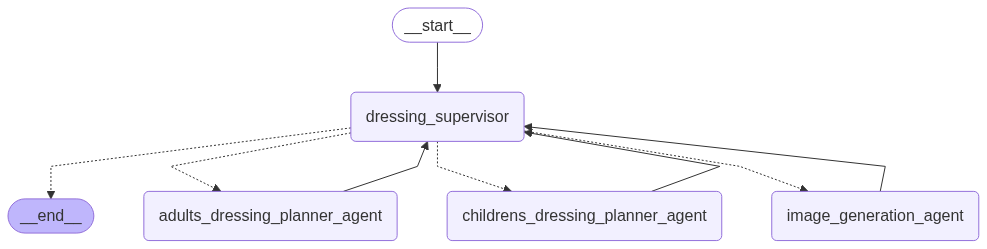

In [15]:
from IPython.display import display, Image

display(Image(hierarchy.get_graph().draw_mermaid_png()))
display(Image(weather_team.get_graph().draw_mermaid_png()))
display(Image(dressing_team.get_graph().draw_mermaid_png()))

In [ ]:

for s in hierarchy.stream(
    {"messages": [("user", "I live in London, I am 90 year old")]}, {"recursion_limit": 100}, subgraphs=True,debug=True):
    print(s)
    print("============================")